In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from deep_convnet import DeepConvNet
%matplotlib inline

from common.functions import softmax

Using TensorFlow backend.


In [2]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# 正規化
x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0

In [3]:
eps = 0.3

In [4]:
random_noise = np.random.normal(
    loc   = 0,      # 平均
    scale = 1,      # 標準偏差
    size  = (28, 28),# 出力配列のサイズ
)
random_noise

array([[-0.95331541,  1.01230524,  1.1942028 , -0.75243676, -1.36299895,
        -2.07336421,  0.12753199, -1.7174897 , -0.27970097,  0.39187989,
        -1.78663778, -1.13649224, -0.09822586, -1.18425289,  0.05769657,
         0.06116674,  0.9082543 ,  0.2225309 ,  0.78051103, -0.31766085,
         1.53977572,  1.32616824, -1.92616714,  0.28107303, -0.67978248,
        -0.20957314, -0.06490005, -0.77518136],
       [-0.18668005, -1.28111669,  0.79484533, -0.85784053,  0.38490337,
         1.23766954,  0.05347593,  0.69445905, -0.99035794, -0.30914212,
         1.0834587 , -1.06306558, -1.32972064,  0.36753505, -0.90551068,
        -0.85398166, -1.11265683, -0.61135119, -0.10923478,  1.28462204,
        -0.58197577, -0.17538457, -0.45840284,  0.23239454, -1.0793892 ,
         0.0572737 ,  1.74804248,  0.91610717],
       [ 0.60951986,  1.04402781,  0.88247584, -1.3172764 , -0.70558527,
         0.01908447,  0.06807867, -0.49850408, -0.38932752,  1.41690713,
        -0.47428701,  1.7711

(-5, 5)

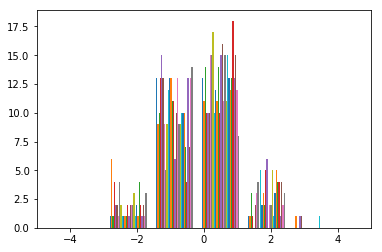

In [5]:
plt.hist(random_noise,bins=5)
plt.xlim(-5,5)

In [6]:
randomed_x_test = (x_test + np.sign(random_noise) * eps).clip(min=0, max=1)
randomed_x_test.shape

(10000, 28, 28)

In [7]:
x_test = x_test.reshape(-1, 1, 28, 28)
randomed_x_test = randomed_x_test.reshape(-1, 1, 28, 28)

In [8]:
network = DeepConvNet()

network.load_params("deep_convnet_params.pkl")
print("loaded Network Parameters!")

loaded Network Parameters!


In [9]:
def generate_adv(x, label, network, eps=0.01):
    d, g = network.gradient_for_fgsm(x.reshape(1, 1, 28, 28), np.array([label]))
    d = d.reshape(28, 28)
    p = eps * np.sign(d)
    adv = (x + p).clip(min=0, max=1)
    adv = adv.reshape(1, 1, 28, 28)
    return adv

In [10]:
def change_adv_list(x_list, t_list, network, eps):
    adv_list = []
    for x, t in zip(x_list, t_list):
        adv = generate_adv(x, t, network, eps)
        adv_list.append(adv.reshape(1, 28, 28))
        
    adv_list = np.array(adv_list)
    return adv_list

In [11]:
fgsm_test = change_adv_list(x_test, t_test, network, eps)
fgsm_test.shape

(10000, 1, 28, 28)

In [12]:
print("無加工に対する正答率：", network.accuracy(x_test, t_test))
print("ランダムノイズに対する正答率：", network.accuracy(randomed_x_test, t_test))
print("FGSMに対する正答率：", network.accuracy(fgsm_test, t_test))

無加工に対する正答率： 0.9925
ランダムノイズに対する正答率： 0.8984
FGSMに対する正答率： 0.3707


左から順に無加工、ランダムノイズ、FGSM


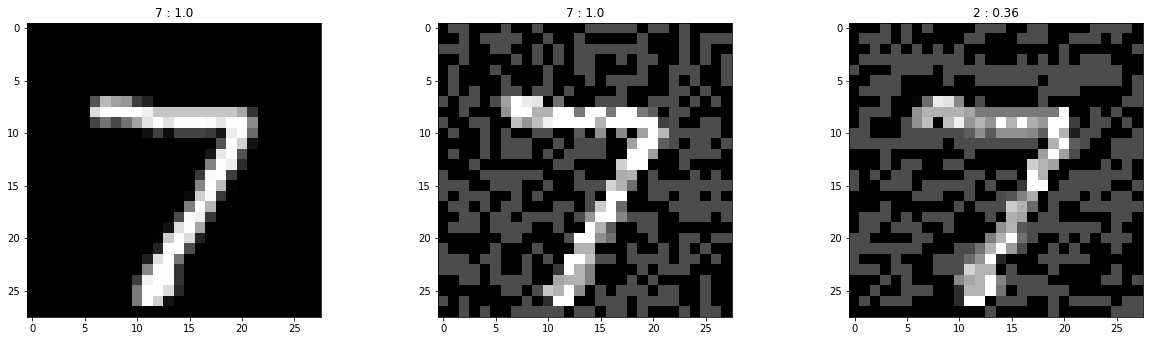

In [13]:
print("左から順に無加工、ランダムノイズ、FGSM")
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(wspace=0.4, hspace=0.1)

for i, x in enumerate([x_test[0], randomed_x_test[0], fgsm_test[0]]):
    x = x.reshape(1, 1, 28, 28)
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(x.reshape(28,28), 'gray')
    pre = network.predict(x)
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 2)
    ax.set_title(f"{pre_label} : {pre_score}")